### Using Opencv and Shapely in Python to Create Polygon Shapes from a Mask Image and then Back to a Mask from Polygons

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
import cv2
from shapely.geometry import MultiPolygon, Polygon
from collections import defaultdict
from skimage.color import rgb2gray
import numpy as np

%matplotlib inline

Image from Nat'l Geographic Kids (http://kids.nationalgeographic.com)

In [25]:
img_file = 'imgs/snowleopard_cub.png'

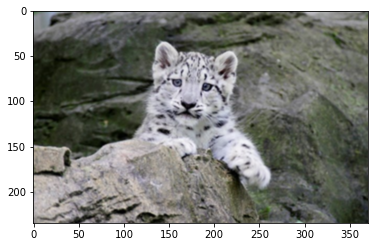

In [26]:
# Matplotlib reads as RGB
img_plt = plt.imread(img_file)
plt.imshow(img_plt, cmap='gray', interpolation='bicubic')

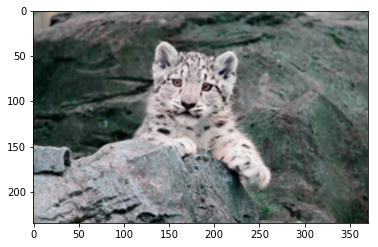

In [27]:
# Read as unchanged so that the transparency is not ignored as it would normally be by default
# Reads as BGR
img_cv2 = cv2.imread(img_file, cv2.IMREAD_UNCHANGED)
plt.imshow(img_cv2, cmap='gray', interpolation='bicubic')

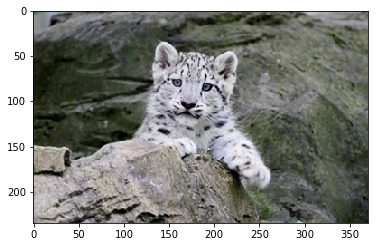

In [28]:
# Convert opencv BGR back to RGB
# See https://www.scivision.co/numpy-image-bgr-to-rgb/ for more conversions
rgb = img_cv2[...,::-1]
plt.imshow(rgb)

In [29]:
def mask_to_polygons(mask, epsilon=10., min_area=10.):
    """Convert a mask ndarray (binarized image) to Multipolygons"""
    # first, find contours with cv2: it's much faster than shapely
    image, contours, hierarchy = cv2.findContours(mask,
                                  cv2.RETR_CCOMP,
                                  cv2.CHAIN_APPROX_NONE)
    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    all_polygons = MultiPolygon(all_polygons)

    return all_polygons

In [30]:
def mask_for_polygons(polygons, im_size):
    """Convert a polygon or multipolygon list back to
       an image mask ndarray"""
    img_mask = np.zeros(im_size, np.uint8)
    if not polygons:
        return img_mask
    # function to round and convert to int
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask

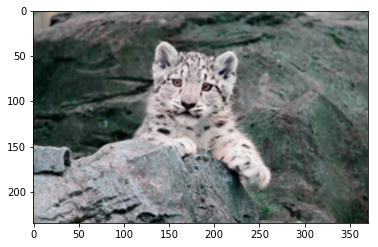

In [31]:
# Read in image unchanged
img = cv2.imread(img_file, cv2.IMREAD_UNCHANGED)

# View
plt.imshow(img, cmap='gray', interpolation='bicubic')

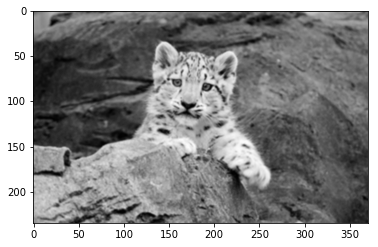

In [32]:
# Convert to a luminance image or an array which is the same size as
# the input array, but with the channel dimension removed - flattened
BW = rgb2gray(img)

# View
plt.imshow(BW, cmap='gray', interpolation='bicubic')

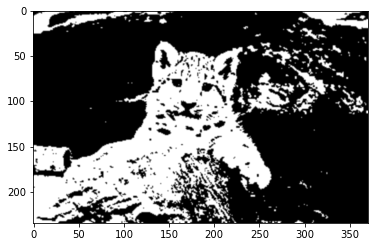

In [33]:
# Convert to CV_8UC1 for creating polygons with shapely
# CV_8UC1 is an 8-bit unsigned integer with 1 channel
BW = cv2.convertScaleAbs(BW)

# View
plt.imshow(BW, cmap='gray', interpolation='bicubic')

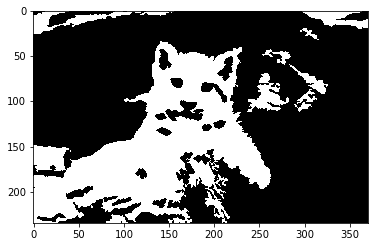

In [34]:
# Get the polygons using shapely
polys = mask_to_polygons(BW, min_area=50)

# Convert the polygons back to a mask image to validate that all went well
mask = mask_for_polygons(polys, BW.shape[:2])

# View - you'll see some loss in detail compared to the before-polygon 
# image if min_area is high - go ahead and try different numbers!
plt.imshow(mask, cmap='gray', interpolation='nearest')

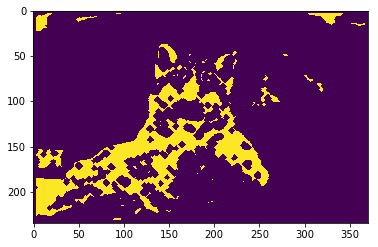

In [35]:
im2, contours, hierarchy = cv2.findContours(BW, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
plt.imshow(cv2.drawContours(im2, contours, -1, (0,255,0), 3))